# Pipeline for BIAPT lab EEG Preprocessing: 
#### inspired by: https://github.com/hoechenberger/pybrain_mne/
#### adapted by: Charlotte Maschke, Beatrice PDK and Victoria Sus
#### This pipeline uses MNE Python to preprocess EEG data: Plese go here: 
####                                https://mne.tools/stable/overview/index.html
####  for more documentation on MNE Python

## Some setup and import

In [1]:
import matplotlib
#import mne_bids
import pathlib
import mne
import os
import os.path as op
import sklearn 
from mne import viz

# interactive plotting functions.


from mne.preprocessing import (ICA, create_eog_epochs, create_ecg_epochs,
                               corrmap)
#import openneuro

#from mne_bids import BIDSPath, read_raw_bids, print_dir_tree, make_report

# Ensure Matplotlib uses the Qt5Agg backend, 
# which is the best choice for MNE-Python's 
# interactive plotting functions.
matplotlib.use('Qt5Agg')

import matplotlib.pyplot as plt

### Which subject do you want to preprocess? 

In [2]:
ID = "004"
session = "07"
task = "post7"

In [3]:
raw_path = "./Data/coma_tacs/sub-{}/ses-{}/eeg/sub-{}_ses-{}_task-{}_eeg.mff".format(ID,session,ID,session,task)
raw_path

'./Data/coma_tacs/sub-004/ses-07/eeg/sub-004_ses-07_task-post7_eeg.mff'

## Load the raw data!

In [4]:
raw = mne.io.read_raw_egi(raw_path)
raw

Reading EGI MFF Header from C:\Users\VivoBook\Documents\GitHub\GitHub_remote_version\Data\coma_tacs\sub-004\ses-07\eeg\sub-004_ses-07_task-post7_eeg.mff...
    Reading events ...
    Assembling measurement info ...


<RawMff | signal1.bin, 129 x 103044 (412.2 s), ~178 kB, data not loaded>

## Resample the data to 250

In [5]:
if raw.info['sfreq'] != 250:
    raw = raw.resample(250)

### Keep only the EEG

In [6]:
# this is to load EEG. If you want to load other stuff please refer to the website documetation
eeg = raw.pick_types(eeg = True)
print('Number of channels in EEG:')
len(eeg.ch_names)

Number of channels in EEG:


129

## Filter the data

In [7]:
# load actual data into system (before it was only metadata)
eeg.load_data()
#eeg.load_data()

# filter the data between 1 to 55 Hz
eeg_filtered = eeg.filter(l_freq=1, h_freq = 55)# we needed to lower the low_pass to 50 because of the presence of a weird machine artifact
#eeg_filtered = eeg.filter(l_freq=1, h_freq = 55) 

# notch filter the data for freq =60
eeg_notch = eeg_filtered.copy().notch_filter(freqs= 60)
#eeg_notch = eeg_filtered.notch_filter(freqs=60)


Reading 0 ... 103043  =      0.000 ...   412.172 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 55 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 55.00 Hz
- Upper transition bandwidth: 13.75 Hz (-6 dB cutoff frequency: 61.88 Hz)
- Filter length: 825 samples (3.300 sec)

Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upp

In [8]:
%matplotlib qt
viz.plot_raw_psd(eeg_notch, exclude = ['E129'], fmax = 70)
if not os.path.exists('./out_figures2/coma_tacs/sub-{}/ses-{}/task-{}'.format(ID,session,task)) :
    os.makedirs('./out_figures2/coma_tacs/sub-{}/ses-{}/task-{}'.format(ID,session,task))
plt.savefig('./out_figures2/coma_tacs/sub-{}/ses-{}/task-{}/sub-{}_ses-{}_task-{}_PSD_raw_filtered.png'.format(ID,session,task,ID,session,task))

Effective window size : 8.192 (s)


## Crop the data

Depending on the data, we may need to crop the begining or/and the end

In [ ]:
eeg_notch.plot(duration=10, n_channels=120, title='raw')

Select if begining and end should be cropped and adapt next line accordingly

In [9]:
eeg_cropped= eeg_notch.crop(tmin=2.0, tmax=410.0)

In [ ]:
#eeg_cropped.plot(duration=10, n_channels=120,title='cropped')

In [ ]:
#eeg_cropped

## Visualize raw data to identify bad channels

Using matplotlib as 2D backend.


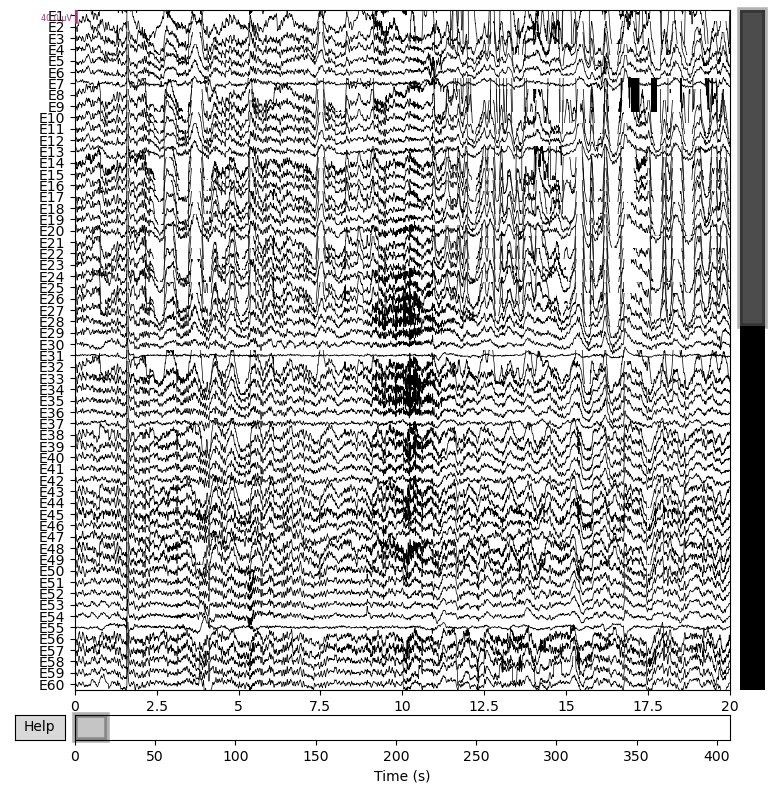

Channels marked as bad: ['E2', 'E8']


In [10]:
eeg_cropped.plot(n_channels=60, duration=20)

Verify if labelled correctly

In [11]:
marked_bad = eeg_cropped.info['bads']
marked_bad

['E2', 'E8']

In [ ]:
#eeg_cropped.plot(n_channels =30, duration=20)

In [12]:
# save in a txt
if not os.path.exists('./eeg_output2/coma_tacs/sub-{}/ses-{}/eeg'.format(ID,session)) :
    os.makedirs('./eeg_output2/coma_tacs/sub-{}/ses-{}/eeg'.format(ID,session))
with open('./eeg_output2/coma_tacs/sub-{}/ses-{}/eeg/sub-{}_ses-{}_task-{}_marked_bads.json'.format(ID,session,ID,session,task), 'w') as outfile:
    outfile.write("\n".join(marked_bad))


## Remove bad channels

In [13]:
eeg_cropped_removed = eeg_cropped.copy().drop_channels(eeg_cropped.info['bads'])

In [ ]:
#eeg_cropped_removed.plot(n_channels =30, duration=20)

# Make epochs of 10 s

In [ ]:
#Length of epochs = 10 sec because shorter epochs do not allow detection of all frequencies

In [14]:
epochs = mne.make_fixed_length_epochs(eeg_cropped_removed, duration = 10, overlap=0)

Not setting metadata
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated


In [ ]:
epochs  #verify initial number

### Reject epochs with amplitude bigger than 2000 µVolt 

In [15]:
#Peak to peak amplitude on brain scalp > 2000 µVolt are epochs not link with physiological causes 
# physiological amplitude accepted < 800 µVolt

Loading data for 40 events and 2500 original time points ...
0 bad epochs dropped
    Rejecting  epoch based on EEG : ['E1', 'E122', 'E125']
    Rejecting  epoch based on EEG : ['E1', 'E60']
    Rejecting  epoch based on EEG : ['E116', 'E117', 'E123']
    Rejecting  epoch based on EEG : ['E1', 'E26', 'E27', 'E32', 'E33', 'E34', 'E108', 'E114', 'E115', 'E116', 'E122']
    Rejecting  epoch based on EEG : ['E39']
    Rejecting  epoch based on EEG : ['E114', 'E115', 'E122']
    Rejecting  epoch based on EEG : ['E39']
    Rejecting  epoch based on EEG : ['E99', 'E100', 'E101', 'E107', 'E108', 'E115', 'E116', 'E122']
    Rejecting  epoch based on EEG : ['E54', 'E100']
    Rejecting  epoch based on EEG : ['E62', 'E79']
    Rejecting  epoch based on EEG : ['E9', 'E10', 'E14', 'E15', 'E16', 'E17', 'E18', 'E21', 'E22', 'E23', 'E25', 'E26', 'E32', 'E124']
    Rejecting  epoch based on EEG : ['E9', 'E10', 'E14', 'E15', 'E17']
    Rejecting  epoch based on EEG : ['E9', 'E100']
    Rejecting  epoch 

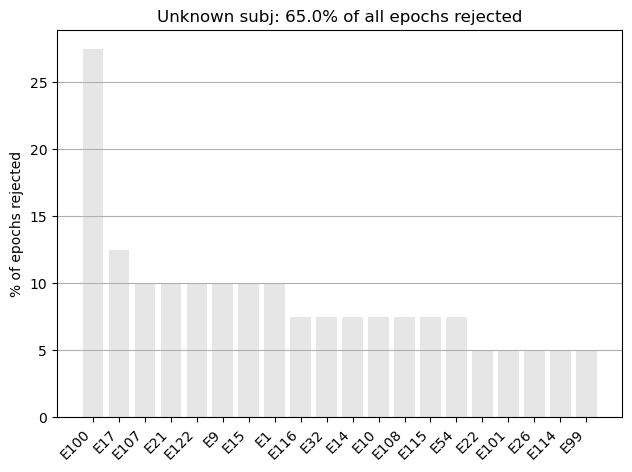

In [16]:
epochs_clean = epochs.copy().load_data()
epochs_clean.drop_bad({'eeg':2000*1e-6})
epochs_clean.plot_drop_log()

In [17]:
epochs_clean

<Epochs |  14 events (all good), 0 - 9.996 sec, baseline off, ~34.1 MB, data loaded,
 '1': 14>

### Drop bad channels imply in bad epochs

In [22]:
bad_channels_bad_epochs=['E100', 'E17']

Loading data for 40 events and 2500 original time points ...
0 bad epochs dropped
    Rejecting  epoch based on EEG : ['E1', 'E122', 'E125']
    Rejecting  epoch based on EEG : ['E1', 'E60']
    Rejecting  epoch based on EEG : ['E116', 'E117', 'E123']
    Rejecting  epoch based on EEG : ['E1', 'E26', 'E27', 'E32', 'E33', 'E34', 'E108', 'E114', 'E115', 'E116', 'E122']
    Rejecting  epoch based on EEG : ['E39']
    Rejecting  epoch based on EEG : ['E114', 'E115', 'E122']
    Rejecting  epoch based on EEG : ['E39']
    Rejecting  epoch based on EEG : ['E99', 'E101', 'E107', 'E108', 'E115', 'E116', 'E122']
    Rejecting  epoch based on EEG : ['E54']
    Rejecting  epoch based on EEG : ['E62', 'E79']
    Rejecting  epoch based on EEG : ['E9', 'E10', 'E14', 'E15', 'E16', 'E18', 'E21', 'E22', 'E23', 'E25', 'E26', 'E32', 'E124']
    Rejecting  epoch based on EEG : ['E9', 'E10', 'E14', 'E15']
    Rejecting  epoch based on EEG : ['E9']
    Rejecting  epoch based on EEG : ['E88']
    Rejecting  

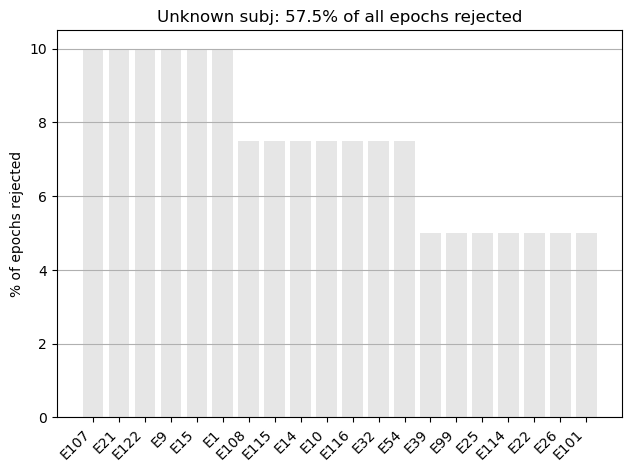

In [23]:
epochs_clean = epochs.copy().load_data()
epochs_clean.drop_channels(bad_channels_bad_epochs) #add bad channels and run the cell again + don't forget to add them in marked_bad
epochs_clean.drop_bad({'eeg':2000*1e-6})
epochs_clean.plot_drop_log()

In [24]:
epochs_clean

<Epochs |  17 events (all good), 0 - 9.996 sec, baseline off, ~40.7 MB, data loaded,
 '1': 17>

#### Add bad channels to the list marked_bad to avoid trouble when it comes to drop non_brain channels

In [25]:
for e in bad_channels_bad_epochs: 
    marked_bad.append(e)

In [ ]:
#epochs_clean.plot(n_epochs=5, n_channels=100, scalings=20e-6)

    Using multitaper spectrum estimation with 7 DPSS windows


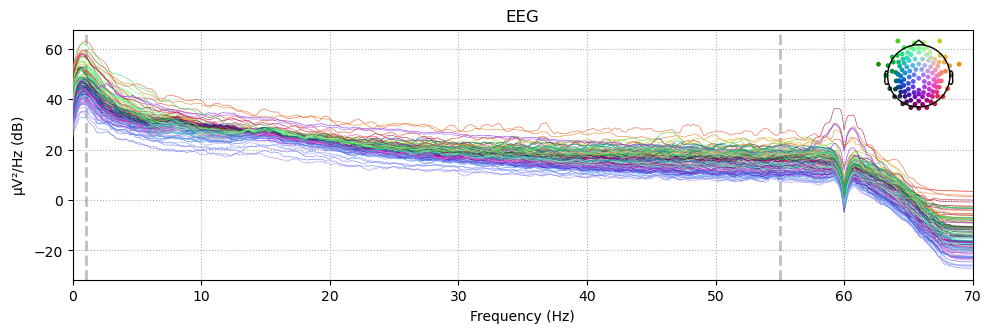

In [27]:
%matplotlib qt
epochs_clean.plot_psd(fmax=70, exclude = ['E129'])
#if not os.path.exists('./out_figures2/coma_tacs/sub-{}/ses-{}/task-{}'.format(ID,session,task)) :
#    os.makedirs('./out_figures2/coma_tacs/sub-{}/ses-{}/task-{}'.format(ID,session,task))
#plt.savefig('./out_figures2/coma_tacs/sub-{}/ses-{}/task-{}/sub-{}_ses-{}_task-{}_PSD_epochs_filtered.png'.format(ID,session,task,ID,session,task))

## Drop additionnal channels afterwards if necessarry

In [ ]:
#Select bad channels on the plot
epochs_clean.plot(n_epochs=10, n_channels=60, scalings=20e-6)

#### Add bad channels to the list marked_bad to avoid trouble when it comes to drop non_brain channels

In [ ]:
#marked_bad

In [ ]:
#epochs_clean.info['bads']

In [ ]:
for e in bad_channels_bad_epochs: 
    marked_bad.append(e)

In [ ]:
#marked_bad

In [ ]:
epochs_clean.load_data()
epochs_clean = epochs_clean.copy().drop_channels(epochs_clean.info['bads'])

In [ ]:
#epochs_clean.plot(n_epochs=10, n_channels=60, scalings=20e-6)

In [ ]:
#epochs_clean.info

# RUN ICA

## Manual selection of ICA components

In [ ]:
#Number of components = 30 because it's better to have as many components as possible (up to the nb of electrodes ~100 after clearing and rejection of non brain)
# 30 is a good compromise

In [29]:
from mne.preprocessing import (ICA, create_eog_epochs, create_ecg_epochs,
                               corrmap)

ica = ICA(n_components=30, max_iter='auto', random_state=97)
ica.fit(epochs_clean)

Fitting ICA to data using 125 channels (please be patient, this may take a while)
Selecting by number: 30 components
Fitting ICA took 5.2s.


<ICA | epochs decomposition, method: fastica (fit in 77 iterations on 42500 samples), 30 ICA components explaining 96.5 % of variance (125 PCA components available), channel types: eeg, no sources marked for exclusion>

Not setting metadata
Not setting metadata
17 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


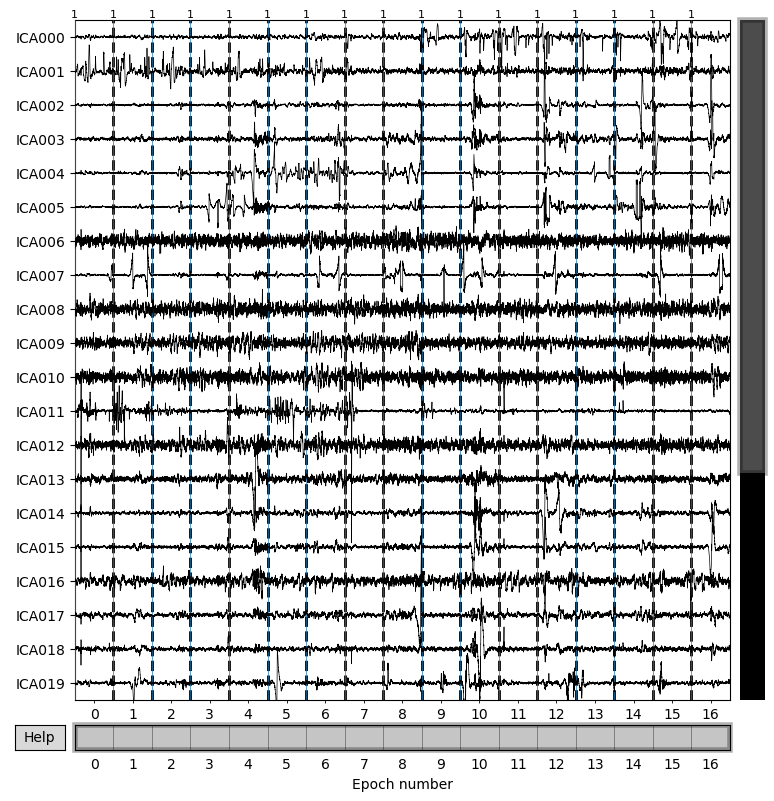

In [30]:
ica.plot_sources(epochs_clean)

In [36]:
ica.plot_components(inst=epochs_clean)

[<MNEFigure size 975x967 with 20 Axes>, <MNEFigure size 975x496 with 10 Axes>]

In [37]:
ica.plot_properties(epochs_clean, picks=ica.exclude)

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
Not setting metadata
17 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
17 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
17 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


[<Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>]

In [ ]:
ica

Double check which component to remove: 

In [ ]:
ica.exclude

In [ ]:
len(ica.exclude)

## Remove component definetely

In [38]:
epochs_clean.load_data()
eeg_postica= ica.apply(epochs_clean.copy())


Applying ICA to Epochs instance
    Transforming to ICA space (30 components)
    Zeroing out 3 ICA components
    Projecting back using 125 PCA components


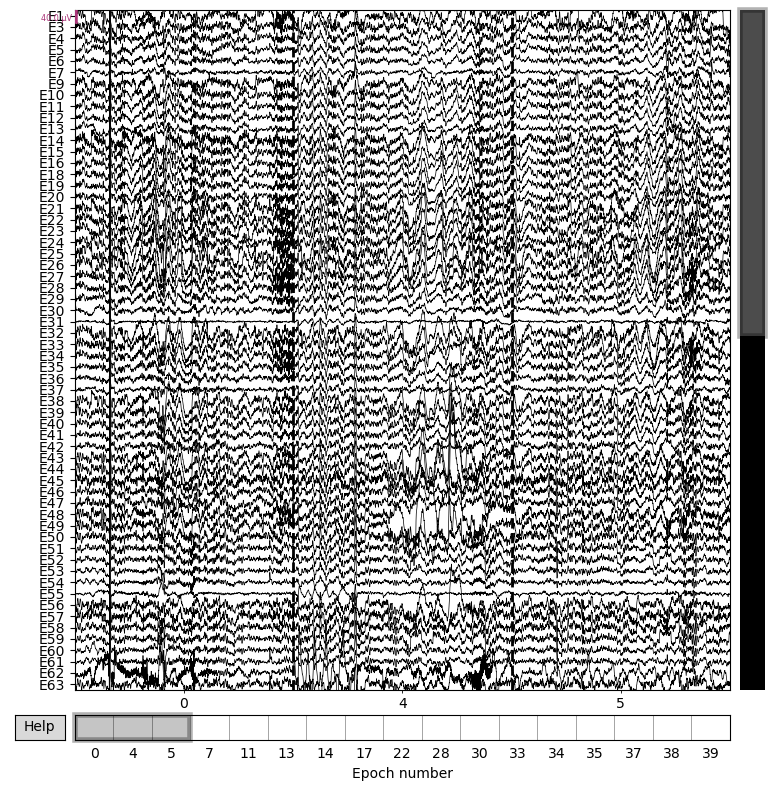

C:\Users\VivoBook\anaconda3\lib\site-packages\mne\viz\_mpl_figure.py:1779: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  _cols = np.array([self.mne.epoch_color_bad,
C:\Users\VivoBook\anaconda3\lib\site-packages\mne\viz\_mpl_figure.py:1779: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  _cols = np.array([self.mne.epoch_color_bad,
C:\Users\VivoBook\anaconda3\lib\site-packages\mne\viz\_mpl_figure.py:1779: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different len

Dropped 0 epochs: 
Channels marked as bad: none
Dropped 0 epochs: 
Channels marked as bad: none


In [39]:
# PLot to compare both signals pre and post ICA
epochs_clean.plot(title='raw', n_epochs=3, n_channels=60, scalings=20e-6)
eeg_postica.plot(title='ICA correction', n_epochs=3, n_channels=60, scalings=20e-6)

In [ ]:
eeg_postica

    Using multitaper spectrum estimation with 7 DPSS windows


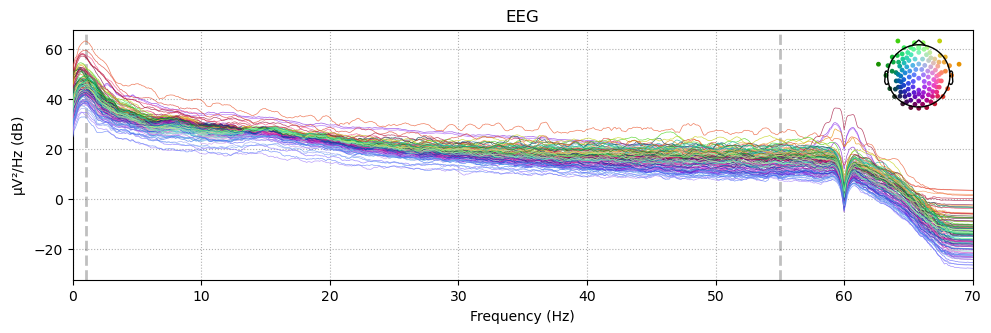

In [40]:
%matplotlib qt
eeg_postica.plot_psd(exclude = ['E129'], fmax = 70)
#if not os.path.exists('./out_figures2/coma_tacs/sub-{}/ses-{}/task-{}'.format(ID,session,task)) :
#    os.makedirs('./out_figures2/coma_tacs/sub-{}/ses-{}/task-{}'.format(ID,session,task))
#plt.savefig('./out_figures2/coma_tacs/sub-{}/ses-{}/task-{}/sub-{}_ses-{}_task-{}_PSD_epochs_post_ica.png'.format(ID,session,task,ID,session,task))

## Average Reference the data

In [41]:
# use the average of all channels as reference
eeg_avg_ref = eeg_postica.set_eeg_reference(ref_channels='average')

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


In [42]:
#eeg_avg_ref.plot(title='Avg ref', n_epochs=3, n_channels=100, scalings=20e-6)

    Using multitaper spectrum estimation with 7 DPSS windows


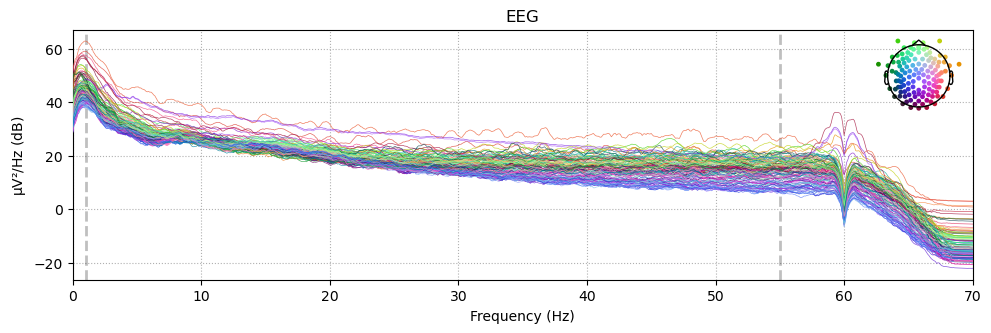

In [43]:
%matplotlib tk
eeg_avg_ref.plot_psd(fmax=70)
#if not os.path.exists('./out_figures2/coma_tacs/sub-{}/ses-{}/task-{}'.format(ID,session,task)) :
#    os.makedirs('./out_figures2/coma_tacs/sub-{}/ses-{}/task-{}'.format(ID,session,task))
#plt.savefig('./out_figures2/coma_tacs/sub-{}/ses-{}/task-{}/sub-{}_ses-{}_task-{}_PSD_avg_ref.png'.format(ID,session,task,ID,session,task))

In [ ]:
eeg_avg_ref.info

## Identify remaining  bad channels

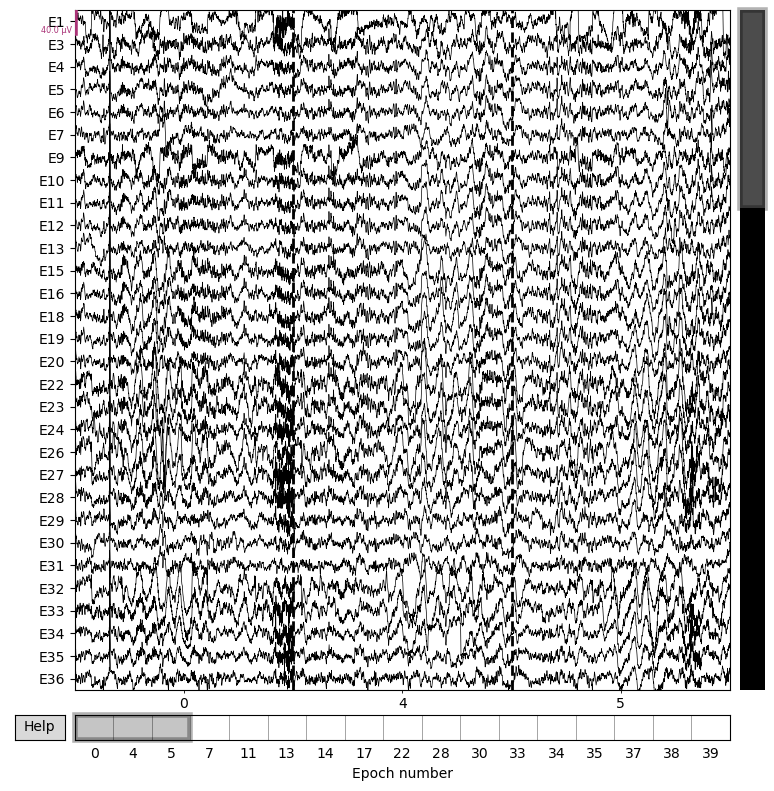

Dropped 0 epochs: 
Channels marked as bad: ['E107', 'E127', 'E126', 'E21', 'E14', 'E25', 'E128', 'E125', 'E43', 'E120', 'E48', 'E119', 'E49', 'E113', 'E81', 'E73', 'E88', 'E68', 'E94', 'E63', 'E99', 'E56', 'E107', 'E62', 'E79']


In [53]:
eeg_avg_ref.plot(title='Identify remaining bad channels', n_epochs=3, n_channels=30, scalings=20e-6)

## Remove Non-Brain Electrodes 

In [54]:
non_brain_el = ['E127', 'E126', 'E17', 'E21', 'E14', 'E25', 'E8', 'E128', 'E125', 'E43', 'E120', 'E48', 
                'E119', 'E49', 'E113', 'E81', 'E73', 'E88', 'E68', 'E94', 'E63', 'E99', 'E56', 'E107' ]

#only add non-brain channels if not already part of noisy channels
for e in non_brain_el: 
    if e not in marked_bad :
        eeg_avg_ref.info['bads'].append(e)


In [ ]:
#print(eeg_avg_ref.info['bads'])

In [55]:
# remove non-brain channels
eeg_brainonly = eeg_avg_ref.copy().drop_channels(eeg_avg_ref.info['bads'])

## Identify remaining bad epochs

In [56]:
eeg_brainonly  #verify initial number

<Epochs |  17 events (all good), 0 - 9.996 sec, baseline off, ~32.9 MB, data loaded,
 '1': 17>

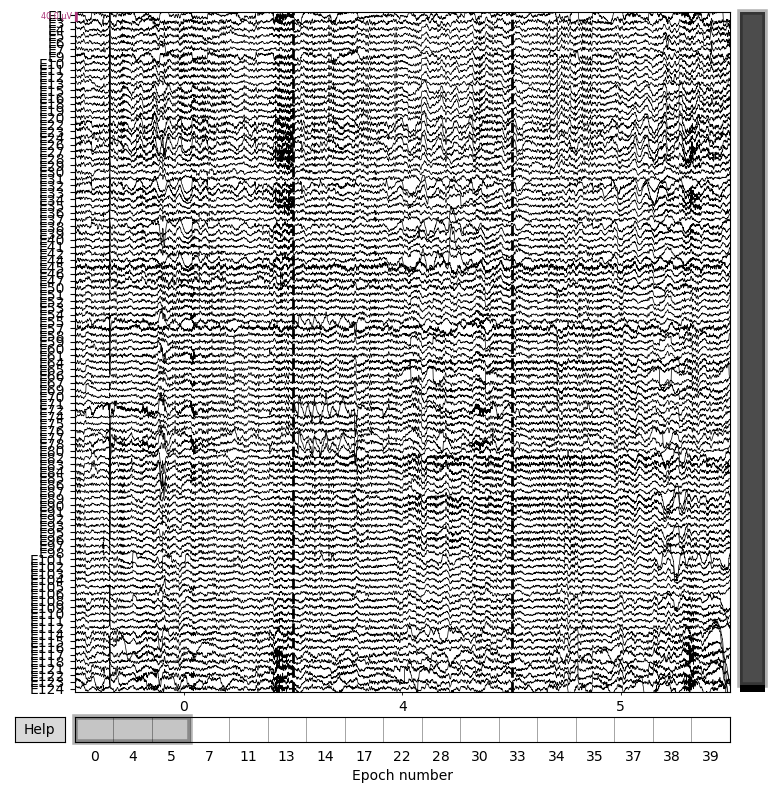

C:\Users\VivoBook\anaconda3\lib\site-packages\mne\viz\_mpl_figure.py:1779: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  _cols = np.array([self.mne.epoch_color_bad,
C:\Users\VivoBook\anaconda3\lib\site-packages\mne\viz\_mpl_figure.py:1779: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  _cols = np.array([self.mne.epoch_color_bad,
C:\Users\VivoBook\anaconda3\lib\site-packages\mne\viz\_mpl_figure.py:1779: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different len

Dropped 2 epochs: 4, 10
Channels marked as bad: none


In [57]:
eeg_brainonly.plot(title='brain only', n_epochs=3, n_channels=100, scalings=20e-6)

In [49]:
eeg_brainonly #how many left

<Epochs |  15 events (all good), 0 - 9.996 sec, baseline off, ~29.6 MB, data loaded,
 '1': 15>

## Save final non brain data

In [58]:
eeg_brainonly.save("./eeg_output2/coma_tacs/sub-{}/ses-{}/eeg/sub-{}_ses-{}_task-{}_{}_eeg.fif".format(ID, session, ID, session, task, 'epoch'), overwrite=True)
#ici changer pour le sauver dans derivatives, dossier clean (avec un readme expliquant le cleaning) et le fichier sous le bids format

Overwriting existing file.


C:\Users\VivoBook\AppData\Local\Temp\ipykernel_3020\3695097405.py:1: RuntimeWarning: This filename (./eeg_output2/coma_tacs/sub-004/ses-07/eeg/sub-004_ses-07_task-post7_epoch_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  eeg_brainonly.save("./eeg_output2/coma_tacs/sub-{}/ses-{}/eeg/sub-{}_ses-{}_task-{}_{}_eeg.fif".format(ID, session, ID, session, task, 'epoch'), overwrite=True)


Verify psd

In [59]:
%matplotlib qt
eeg_brainonly.plot_psd(fmax=70)
plt.savefig('./out_figures2/coma_tacs/sub-{}/ses-{}/task-{}/sub-{}_ses-{}_task-{}_PSD_brainonly.png'.format(ID,session,task,ID,session,task))

    Using multitaper spectrum estimation with 7 DPSS windows
